## Time to get your hands dirty. The HR diagram

This assignment is about stars...

We will work with a star catalogue of 240 stars described by the following information:

- Temperature (in Kelvin)
- Luminosity (L/Lo)
- Radius (R/Ro)
- Absolute magnitude (Mv)

We also have the following data for each star:

- Color (Red/Orange/Yellow/White/Blue)
- Spectral class ('A', 'B', 'F', 'G', 'K', 'M', 'O')
- Star type (Brown dwarf/Red dwarf/White dwarf/Main sequence/Supergiant/Hypergiant)

This dataset has been collected by [Deepraj Baidya](https://github.com/deepraj1729) and was originally published on [Kaggle](https://www.kaggle.com/deepu1109/star-dataset). 

There are 6 star types that are encoded in the *'Star type'* column. These labels are currently encoded as strings which is practical for reading but not for computing. Using scikit-learn, we will convert this column into integers by assigning a unique int value to each star type.

We've seen this already last time. It is often grood practice to start with a statistical analysis of the dataset to answer the following questions:
* are there any missing values?
* are there NaNs in the data?

Star classification is something that can be done based on rules depending on temperature and luminosity. We can reproduce this diagram by plotting the scatter plot of our stars using the same variables in log-log-scale.

We find the same organization of stars in this 2D plane. Main Sequence stars and White Dwarves are fairly easy to isolate from the rest: a statistical model should be able to easily classify them. Based only on Luminosity and Temperature, Dwarf stars and Giant stars have higher intra-group variability: Supergiant and Hypergiant cover the same space (same for Brown and Red Dwarves). Additionnal variables might be needed to correctly identify the types of those stars.

- Apply PCA to the dataset at your disposal (hint: don't use columns with labels, only those with real numbers).
- Project the dataset into the principal components, and do a scatter plot of the first two. 
- This will look terrible. Think about the units!
- Explore what happens if you rescale the data first.

**This is actually a very important lesson in machine learning**: Massaging your data before giving them to an algorithm can make things much much better.

- You can try an linear, affine transformation such that each dimension goes between -1 and 1.
- Or (which is [the usual machine-learning approach](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)) standardize your data such that each dimension has mean=0 and variance=1. 
- Redo your PCA. Should be much much better.
- How much variance is explained by those two components?



### For later: come back to this assignment after lecture 20
- Now run a supervised classification algorithm on this dataset. 
- Can you predict the stellar type? How well? Careful with overfitting of course.

In [1]:
import urllib.request
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit, ValidationCurveDisplay
from sklearn.linear_model import LogisticRegression

### 1. Data Preprocessing

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/nshaud/ml_for_astro/main/stars.csv", "stars.csv")

('stars.csv', <http.client.HTTPMessage at 0x22d46236fd0>)

In [3]:
df_stars = pd.read_csv("stars.csv")
df_stars

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,Brown Dwarf,Red,M
1,3042,0.000500,0.1542,16.60,Brown Dwarf,Red,M
2,2600,0.000300,0.1020,18.70,Brown Dwarf,Red,M
3,2800,0.000200,0.1600,16.65,Brown Dwarf,Red,M
4,1939,0.000138,0.1030,20.06,Brown Dwarf,Red,M
...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,Hypergiant,Blue,O
236,30839,834042.000000,1194.0000,-10.63,Hypergiant,Blue,O
237,8829,537493.000000,1423.0000,-10.73,Hypergiant,White,A
238,9235,404940.000000,1112.0000,-11.23,Hypergiant,White,A


To help the classifier, I convert the star type column by substituting the string values with numbers.

In [4]:
le = LabelEncoder()
# Assign unique integers from 0 to 6 to each star type
df_stars['Star type'] = le.fit_transform(df_stars['Star type'])
labels_star_type = le.inverse_transform(df_stars['Star type'])
class_names_star_type = le.classes_
print(class_names_star_type)
le = LabelEncoder()
df_stars['Star color'] = le.fit_transform(df_stars['Star color'])
labels_star_color = le.inverse_transform(df_stars['Star color'])
class_names_star_color  = le.classes_
print(class_names_star_color)
le = LabelEncoder()
df_stars['Spectral Class'] = le.fit_transform(df_stars['Spectral Class'])
labels_spectral_class = le.inverse_transform(df_stars['Spectral Class'])
class_names_spectral_class = le.classes_
print(class_names_spectral_class)

['Brown Dwarf' 'Hypergiant' 'Main Sequence' 'Red Dwarf' 'Supergiant'
 'White Dwarf']
['Blue' 'Blue ' 'Blue White' 'Blue white' 'Blue white ' 'Blue-White'
 'Blue-white' 'Orange' 'Orange-Red' 'Pale yellow orange' 'Red' 'White'
 'White-Yellow' 'Whitish' 'Yellowish' 'Yellowish White' 'white'
 'yellow-white' 'yellowish']
['A' 'B' 'F' 'G' 'K' 'M' 'O']


In [5]:
df_stars.columns

Index(['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)',
       'Absolute magnitude(Mv)', 'Star type', 'Star color', 'Spectral Class'],
      dtype='object')

### 2. Visualizing data: HR Diagram

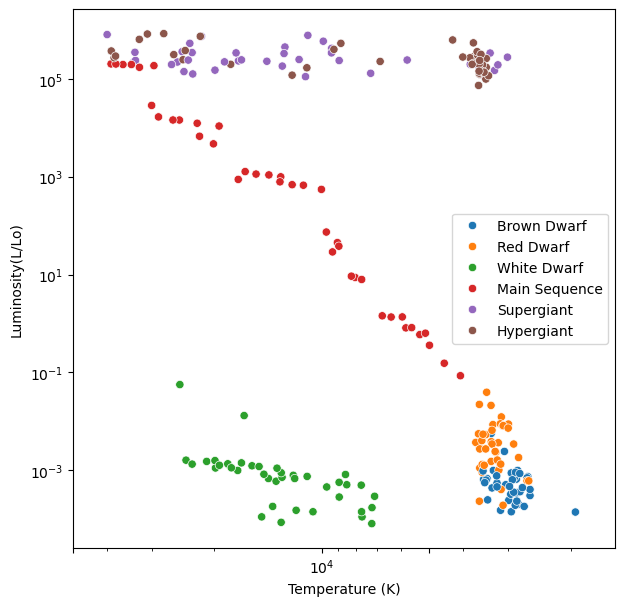

In [6]:
fig = plt.figure(figsize=(7, 7))
sns.scatterplot(data=df_stars, x='Temperature (K)', y='Luminosity(L/Lo)', hue=labels_star_type)

plt.xscale('log')
plt.yscale('log')
plt.xticks([5000, 10000, 50000])
plt.xlim(5e4, 1.5e3)
plt.show()

### 3. PCA

To reduce the dimensionality of my data, I apply a Principal Component Analysis. I studied two cases: one in which I leave the data unscaled, another in which I scale the data before applying the PCA.

In [7]:
scaler = StandardScaler().set_output(transform="pandas")


X_train, X_test, y_train, y_test = train_test_split(df_stars.loc[:, 'Temperature (K)':'Absolute magnitude(Mv)'], 
                                                    df_stars['Star type'], test_size=0.3, random_state=42)

scaled_X_train = scaler.fit_transform(X_train)

To understand how the scaling impact the PCA, I plot the weights for each feature on the first principal component

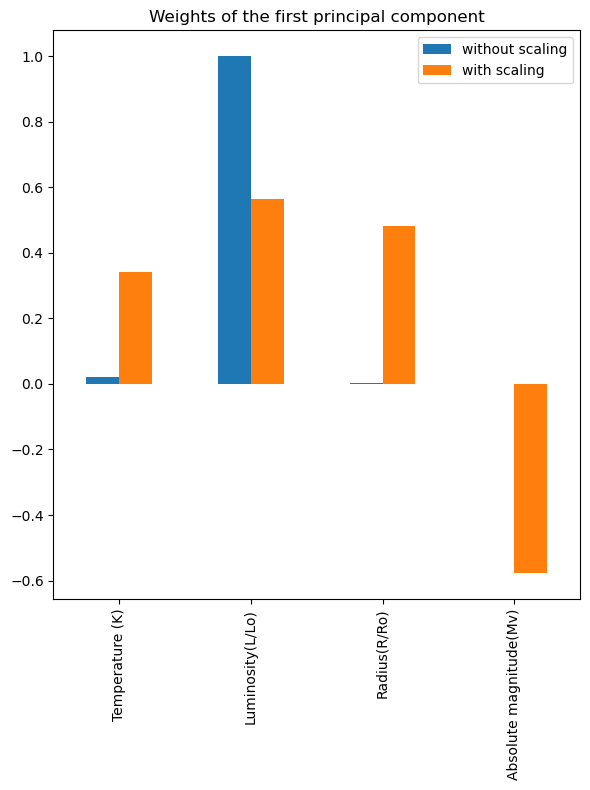

In [8]:
pca = PCA(n_components=2).fit(X_train)
scaled_pca = PCA(n_components=2).fit(scaled_X_train)
X_train_transformed = pca.fit_transform(X_train)
X_train_scaled_transformed = scaled_pca.fit_transform(scaled_X_train)

first_pca_component = pd.DataFrame(
    pca.components_[0], index=df_stars.columns[0:4], columns=["without scaling"]
)
first_pca_component["with scaling"] = scaled_pca.components_[0]
first_pca_component.plot.bar(
    title="Weights of the first principal component", figsize=(6, 8)
)

_ = plt.tight_layout()

From this plot it is possible to notice that leaving the data unscaled results on an heavier impact from the Luminosity, while the other features are less considered. Instead, if we scaled the data first, the weights are much more distributed on all the features.

#### 2.1: Visualizing the Transformed Data

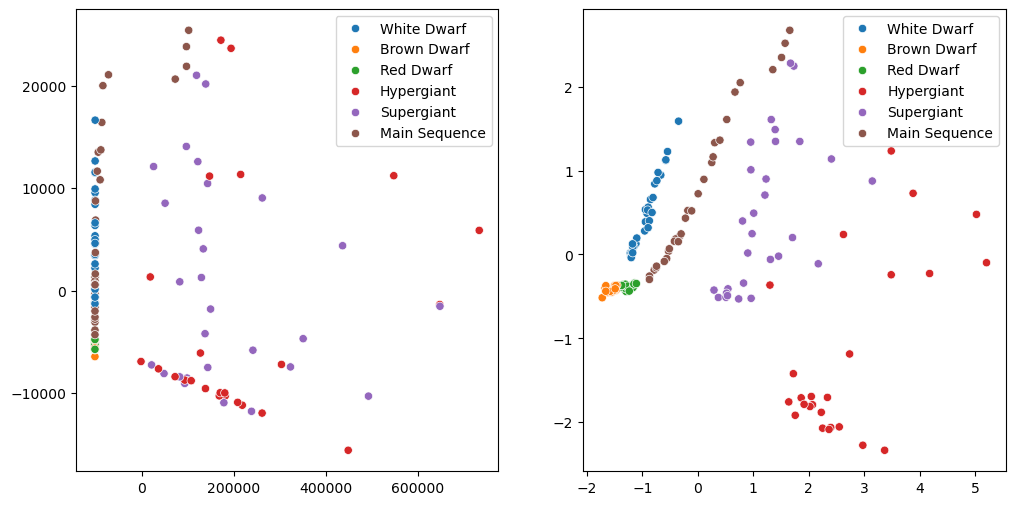

In [9]:
fig = plt.figure(figsize =(12,6))
ax = fig.add_subplot(1,2,1)
sns.scatterplot(x = X_train_transformed[:, 0], y = X_train_transformed[:,1], hue = class_names_star_type[y_train])

ax2 = fig.add_subplot(1,2,2)
sns.scatterplot(x = X_train_scaled_transformed[:, 0], y = X_train_scaled_transformed[:,1], hue = class_names_star_type[y_train]);


From this plot, we can see how the data are much more separated, since the PCA was able to find the components that maximizes the variances. Note that this is mostly the case for the scaled dataset, as we can see that for the unscaled dataset the PCA is unable to perfectly separate all the different classes.

We can see how the PCA acts on a test subset for both cases.

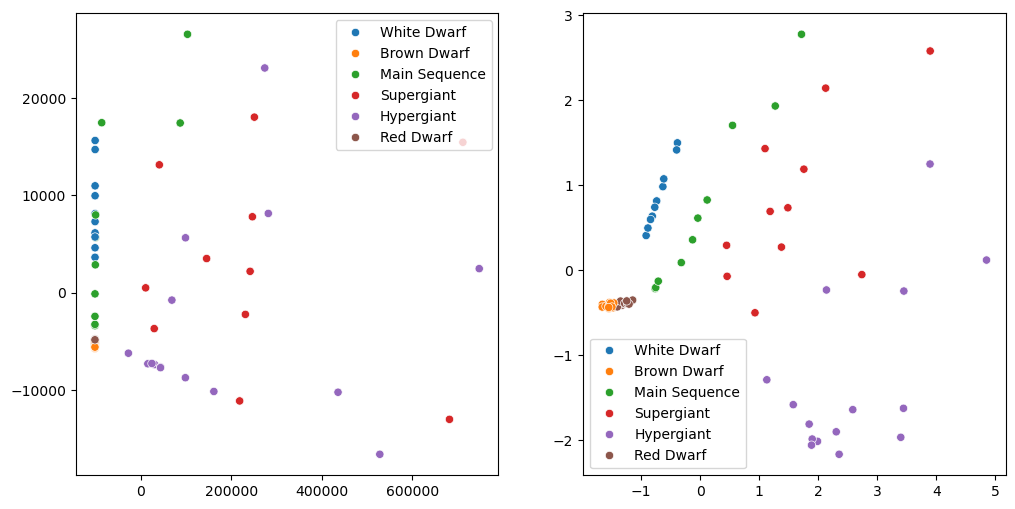

In [10]:
scaled_X_test = scaler.transform(X_test)
X_test_transformed = pca.transform(X_test)
X_test_scaled_transformed = scaled_pca.transform(scaled_X_test)

fig = plt.figure(figsize =(12,6))
ax = fig.add_subplot(1,2,1)
sns.scatterplot(x = X_test_transformed[:, 0], y = X_test_transformed[:,1], hue = class_names_star_type[y_test])

ax2 = fig.add_subplot(1,2,2)
sns.scatterplot(x = X_test_scaled_transformed[:, 0], y = X_test_scaled_transformed[:,1], hue = class_names_star_type[y_test]);

As expected, the scaled PCA is more able to correctly transformed the testing dataset. In fact, this is visible by the fact that the test subset are plotted in the same regions as the training subset in the PCA components with respect to their labels (Note: the colors of the labels in the two plots are different).

<Axes: >

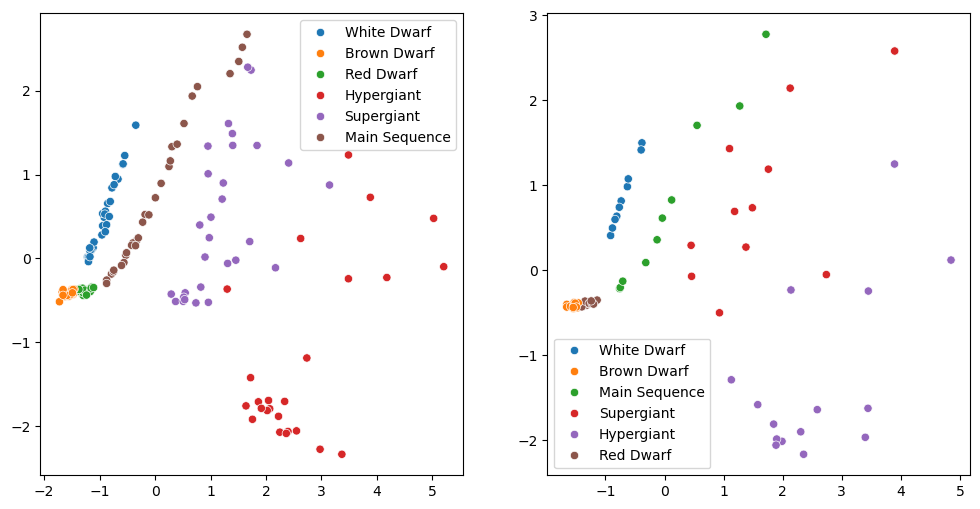

In [11]:
fig = plt.figure(figsize =(12,6))
ax = fig.add_subplot(1,2,1)
sns.scatterplot(x = X_train_scaled_transformed[:, 0], y = X_train_scaled_transformed[:,1], hue = class_names_star_type[y_train])

ax2 = fig.add_subplot(1,2,2)
sns.scatterplot(x = X_test_scaled_transformed[:, 0], y = X_test_scaled_transformed[:,1], hue = class_names_star_type[y_test])

### 3.0 Logistic Regression

Here, I use the dataset with the PCA applied to fit a Logistic Regression and study its performance in predicting the label of my testing subset.

Optimal C for the unscaled PCA: 0.0000

Optimal C for the standardized data with PCA: 784.76


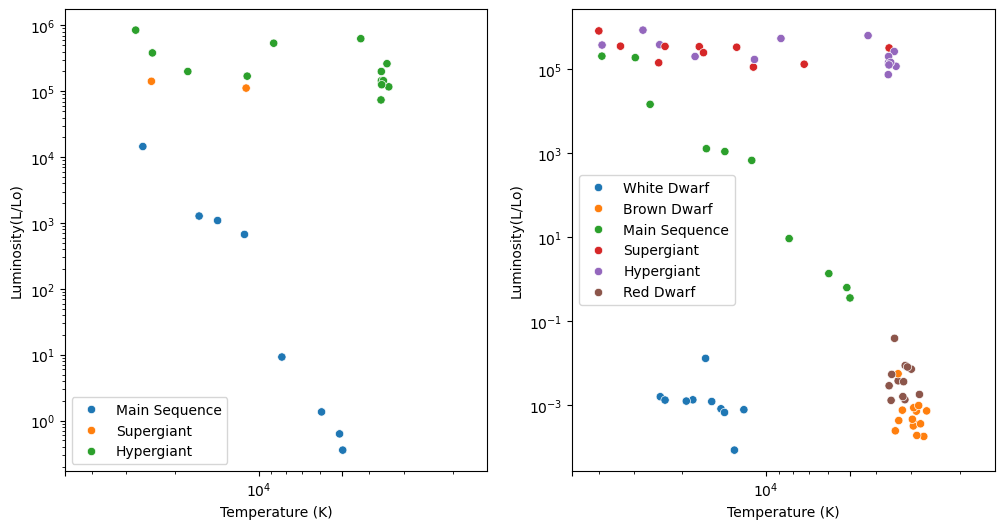

In [12]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import make_pipeline

Cs = np.logspace(-5, 5, 20)

unscaled_clf = make_pipeline(pca, LogisticRegressionCV(Cs=Cs, solver = 'sag',max_iter=5000))
unscaled_clf.fit(X_train, y_train)

scaled_clf = make_pipeline(scaler, pca, LogisticRegressionCV(Cs=Cs, solver = 'sag',max_iter=5000))
scaled_clf.fit(X_train, y_train)

print(f"Optimal C for the unscaled PCA: {unscaled_clf[-1].C_[0]:.4f}\n")
print(f"Optimal C for the standardized data with PCA: {scaled_clf[-1].C_[0]:.2f}")

from sklearn.metrics import accuracy_score

y_pred = unscaled_clf.predict(X_test)
y_pred_scaled = scaled_clf.predict(X_test)
y_proba = unscaled_clf.predict_proba(X_test)
y_proba_scaled = scaled_clf.predict_proba(X_test)

fig = plt.figure(figsize =(12,6))
ax = fig.add_subplot(1,2,1)

condition = class_names_star_type[y_pred] == class_names_star_type[y_test]
sns.scatterplot(data=X_test[condition], x='Temperature (K)', y='Luminosity(L/Lo)', hue=class_names_star_type[y_pred][condition])
plt.xscale('log')
plt.yscale('log')
plt.xticks([5000, 10000, 50000])
plt.xlim(5e4, 1.5e3)

ax2 = fig.add_subplot(1,2,2)
condition = class_names_star_type[y_pred_scaled] == class_names_star_type[y_test]
sns.scatterplot(data = X_test[condition], x='Temperature (K)', y='Luminosity(L/Lo)', hue=class_names_star_type[y_pred_scaled][condition])
plt.xscale('log')
plt.yscale('log')
plt.xticks([5000, 10000, 50000])
plt.xlim(5e4, 1.5e3)
plt.show()

To evaluate the performances of my two model, I use the accuracy and the F1 score. I use the latter to study also the precision of my predictions on all my classes.

In [13]:
print("Test accuracy for the unscaled PCA")
print(f"{accuracy_score(y_test, y_pred):.2%}\n")
print("Test accuracy for the standardized data with PCA")
print(f"{accuracy_score(y_test, y_pred_scaled):.2%}\n")


print("Test F1 score for the unscaled PCA")
print(f"{f1_score(y_test, y_pred, average = 'weighted'):.2%}\n")
print("Test F1 score for the standardized data with PCA")
print(f"{f1_score(y_test, y_pred_scaled, average = 'weighted'):.2%}\n")


Test accuracy for the unscaled PCA
33.33%

Test accuracy for the standardized data with PCA
98.61%

Test F1 score for the unscaled PCA
23.29%

Test F1 score for the standardized data with PCA
98.60%



In [14]:
def plot_cm(labels, predictions, ax):
  cm = confusion_matrix(labels, predictions)
  sns.heatmap(cm, annot=True, fmt="d", ax = ax)
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

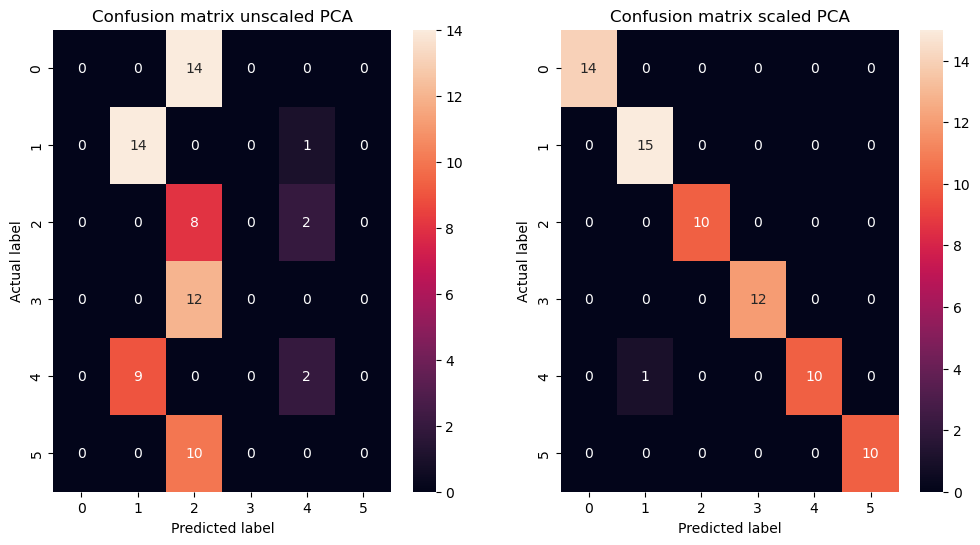

In [15]:
fig = plt.figure(figsize = (12,6))
ax1 = fig.add_subplot(121)
ax1.set_title('Confusion matrix unscaled PCA')
plot_cm(y_test, y_pred, ax1)
ax2 = fig.add_subplot(122)
ax2.set_title('Confusion matrix scaled PCA')
plot_cm(y_test, y_pred_scaled, ax2)

### 4. Learning Curves

Here, I visualize the learning curve of the model

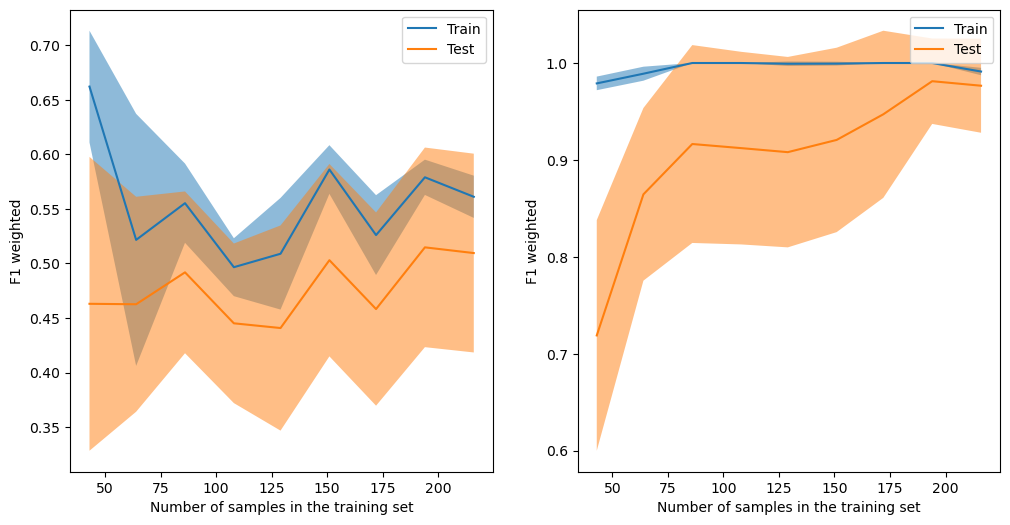

In [16]:
x_sample = df_stars.loc[:, 'Temperature (K)':'Absolute magnitude(Mv)']
x_sample= pca.fit_transform(x_sample)
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
LearningCurveDisplay.from_estimator(LogisticRegressionCV(solver = 'sag',max_iter=5000), x_sample, df_stars['Star type'], 
                                    train_sizes = np.linspace(0.1, 1.0, 10), scoring = 'f1_weighted', cv = 10, n_jobs = -1,
                                   ax = ax1)
x_sample = df_stars.loc[:, 'Temperature (K)':'Absolute magnitude(Mv)']
x_sample = scaler.fit_transform(x_sample)
x_sample = scaled_pca.fit_transform(x_sample)

ax2 = fig.add_subplot(122)
LearningCurveDisplay.from_estimator(LogisticRegressionCV(solver = 'sag',max_iter=5000), x_sample, df_stars['Star type'], 
                                    train_sizes = np.linspace(0.1, 1.0, 10), scoring = 'f1_weighted', cv = 10, n_jobs = -1,
                                   ax = ax2);